Prerequisites

Before running this notebook, the following tasks must be completed:

1. Download + preprocess the data by running `data/luo_2017_mouse.py` and `data/mo_2015_methylC-seq.py`
2. Run `experiment_scripts/test_dss.py`, `experiment_scripts/test_methylkit.py`, and `experiment_scripts/test_scmet.py`
3. Train a MethylVI model by running `experiment_scripts/train_model.py` with the `luo_2017_mouse` dataset

In [1]:
from methyl_vi.model import MethylVI
import mudata
from collections import defaultdict
import scanpy as sc
from scvi import settings
import numpy as np
from utils import get_mm_ensembl_mappings
import diffxpy.api as de
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.stats import fisher_exact
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
from rpy2.robjects import globalenv
from sklearn.metrics import roc_auc_score
import matplotlib.patches as mpatches
import pickle

rpy2.robjects.numpy2ri.activate()

/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarnin

In [2]:
biomart_dict = get_mm_ensembl_mappings()

In [3]:
n_features = "2500"

mdata = mudata.read_h5mu(
    f"/projects/leelab2/metVI/Luo2017_Mouse/data/gene_{n_features}_features.h5mu"
)

bulk_mdata = mudata.read_h5mu(
    f"/projects/leelab2/metVI/Mo_2015_MethylC-seq/data/gene_{n_features}_features.h5mu"
)

In [4]:
excitatory_subtypes = [
    "mL2/3",
    "mL4",
    "mL5-1",
    "mDL-1",
    "mDL-2",
    "mDL-3",
    "mIn-1",
    "mL6-1",
    "mL6-2",
    "mL5-2"
]

def get_neuron_type(x):
    if x in excitatory_subtypes:
        return "Excitatory"
    elif x == "mVip" or x == "mPv":
        return "Inhibitory"
    else:
        return "Other"

mdata.obs['Coarse_type'] = [get_neuron_type(x) for x in mdata.obs["mCG:Neuron type"]]

In [5]:
model = MethylVI.load(
    f"/projects/leelab2/metVI/results/Luo2017_Mouse/gene/{n_features}_features/methylVI/likelihood_betabinomial/dispersion_gene/latent_20/123/model.ckpt",
    adata=mdata
)

INFO     File                                                                                                      
         /projects/leelab2/metVI/results/Luo2017_Mouse/gene/2500_features/methylVI/likelihood_betabinomial/dispersi
         on_gene/latent_20/123/model.ckpt/model.pt already downloaded                                              


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
results_dict = defaultdict(lambda: defaultdict(dict))
correlations = defaultdict(lambda: defaultdict(dict))
limma_vals_dict = defaultdict(dict)

In [7]:
modalities = ['mCG', 'mCH']

for modality in modalities:
    group1 = "Excitatory"
    group2 = "Inhibitory"
    adata = mdata[modality].copy()
    
    raw_frac = adata.layers['mc'] / adata.layers['cov']

    cell_rate_mean = np.nanmean(raw_frac, axis=1)
    cell_rate_var = np.nanvar(raw_frac, axis=1)

    cell_a = (1 - cell_rate_mean) * (cell_rate_mean ** 2) / cell_rate_var - cell_rate_mean
    cell_b = cell_a * (1 / cell_rate_mean - 1)

    post_frac = (adata.layers['mc'] + cell_a[:, None]) / (
                adata.layers['cov'] + cell_a[:, None] + cell_b[:, None])
    prior_mean = cell_a / (cell_a + cell_b)
    post_frac = post_frac / prior_mean[:, None]
    
    adata.X = np.log(post_frac)

    adata.obs['Coarse_type'] = [get_neuron_type(x) for x in adata.obs["Neuron type"]]

    methylVI_results = []
    scmet_results = []

    seeds = [123, 42, 789, 46, 999]
    for seed in seeds:
        model = MethylVI.load(
            f"/projects/leelab2/metVI/results/Luo2017_Mouse/gene/{n_features}_features/methylVI/likelihood_betabinomial/dispersion_gene/latent_20/{seed}/model.ckpt",
            adata=mdata
        )

        results = model.differential_methylation(
            adata=mdata,
            modality=modality,
            groupby="Coarse_type",
            group1=group1,
            group2=group2,
            mode="vanilla",
        )

        results.index = [biomart_dict[x.split(".")[0]] for x in results.index]
        results = results.loc[results.index != ""]
        methylVI_results.append(results)

        scmet_result = pd.read_csv(f"{group1}_vs_{group2}_{n_features}_{modality}_scmet_{seed}.csv", index_col=0)
        scmet_result.index = [biomart_dict[x.split(".")[0]] for x in scmet_result.index]
        scmet_result = scmet_result.loc[scmet_result.index != ""]
        scmet_results.append(scmet_result)

    bulk_results = pd.read_csv(
       f"/projects/leelab2/metVI/Mo_2015_MethylC-seq/data/limma_results_{group1.lower()}_vs_{group2.lower()}_{modality}.csv", index_col="X"
    )

    bulk_results.index = [biomart_dict[x.split(".")[0]] for x in bulk_results.index]
    bulk_results = bulk_results.loc[bulk_results.index != ""]
    
    adata_ = adata[adata.obs['Coarse_type'].isin([group1, group2])]
    cov_df = pd.DataFrame(adata_.layers['cov'])
    cov_df['coarse_type'] = adata_.obs['Coarse_type'].values
    
    mc_df = pd.DataFrame(adata_.layers['mc'])
    mc_df['coarse_type'] = adata_.obs['Coarse_type'].values

    cov_df = cov_df.groupby(['coarse_type']).sum()
    mc_df = mc_df.groupby(['coarse_type']).sum()
    
    sc.tl.rank_genes_groups(
        adata_,
        "Coarse_type",
        use_raw=False,
        n_genes=adata_.X.shape[1],
        method="wilcoxon",
        key_added="rank_genes_groups_wilcox",
    )
    test_wilcoxon = sc.get.rank_genes_groups_df(adata_, group1, key="rank_genes_groups_wilcox")
    test_wilcoxon.set_index("names", inplace=True)
    test_wilcoxon.index = [biomart_dict[x.split(".")[0]] for x in test_wilcoxon.index]
    test_wilcoxon = test_wilcoxon.loc[test_wilcoxon.index != ""]
    test_wilcoxon = test_wilcoxon[~test_wilcoxon.index.duplicated(keep='first')]

    dss_results = pd.read_csv(f"dss_{group1}_{group2}_{modality}_{n_features}.csv", index_col=0)
    dss_results.set_index("chr", inplace=True)
    dss_results.index = [biomart_dict[x.split(".")[0]] for x in dss_results.index]
    dss_results = dss_results.loc[dss_results.index != ""]

    methylkit_results = pd.read_csv(f"methylkit_{group1}_{group2}_{modality}_{n_features}.csv", index_col=0)
    methylkit_results.set_index("chr", inplace=True)
    methylkit_results.index = [biomart_dict[x.split(".")[0]] for x in methylkit_results.index]
    methylkit_results = methylkit_results.loc[methylkit_results.index != ""]

    features_to_keep = np.intersect1d(
        np.intersect1d(
            np.intersect1d(
                np.intersect1d(
                    np.intersect1d(
                        results.index,
                        bulk_results.index
                    ),
                    methylkit_results.index
                ),
                test_wilcoxon.index,
            ),
            dss_results.index
        ),
        scmet_result.index
    )

    for i in range(len(methylVI_results)):
        methylVI_results[i] = methylVI_results[i].loc[features_to_keep]
        methylVI_results[i] = methylVI_results[i][~methylVI_results[i].index.duplicated(keep='first')]

        scmet_results[i] = scmet_results[i].loc[features_to_keep]
        scmet_results[i] = scmet_results[i][~scmet_results[i].index.duplicated(keep='first')]

    bulk_results = bulk_results.loc[features_to_keep]
    test_wilcoxon = test_wilcoxon.loc[features_to_keep]
    methylkit_results = methylkit_results.loc[features_to_keep]
    dss_results = dss_results.loc[features_to_keep]

    bulk_results = bulk_results[~bulk_results.index.duplicated(keep='first')]
    test_wilcoxon = test_wilcoxon[~test_wilcoxon.index.duplicated(keep='first')]
    methylkit_results = methylkit_results[~methylkit_results.index.duplicated(keep='first')]
    dss_results = dss_results[~dss_results.index.duplicated(keep='first')]

    limma_vals = np.sign(bulk_results['t']) * (-np.log(bulk_results['adj.P.Val']))

    wilcoxon_vals = np.sign(test_wilcoxon['scores']) * np.log(test_wilcoxon['pvals_adj'])

    results_dict[modality][f'{group1}_{group2}']['methylVI'] = []
    results_dict[modality][f'{group1}_{group2}']['scMET'] = []

    for i in range(len(methylVI_results)):
        results_dict[modality][f'{group1}_{group2}']['methylVI'].append(methylVI_results[i]['bayes_factor'])
        results_dict[modality][f'{group1}_{group2}']['scMET'].append(scmet_results[i]['mu_LOR'])

    results_dict[modality][f'{group1}_{group2}']["Wilcoxon"] = -np.sign(test_wilcoxon['scores']) * np.log(test_wilcoxon['pvals_adj'])
    results_dict[modality][f'{group1}_{group2}']["methylKit"] = np.sign(methylkit_results['meth.diff']) * np.log(methylkit_results['qvalue'])
    results_dict[modality][f'{group1}_{group2}']["DSS"] = -np.sign(dss_results['stat']) * np.log(dss_results['fdr'])
    
    limma_vals_dict[modality][f'{group1}_{group2}'] = limma_vals

/tmp/ipykernel_1959161/1083890169.py:8: RuntimeWarning: invalid value encountered in divide
  raw_frac = adata.layers['mc'] / adata.layers['cov']


INFO     File                                                                                                      
         /projects/leelab2/metVI/results/Luo2017_Mouse/gene/2500_features/methylVI/likelihood_betabinomial/dispersi
         on_gene/latent_20/123/model.ckpt/model.pt already downloaded                                              
DE...: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.11it/s]
INFO     File                                                                                                      
         /projects/leelab2/metVI/results/Luo2017_Mouse/gene/2500_features/methylVI/likelihood_betabinomial/dispersi
         on_gene/latent_20/42/model.ckpt/model.pt already downloaded                                               


/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:52: RuntimeWarning: invalid value encountered in divide
  mean1 = np.asarray(np.nanmean(mc1 / cov1, axis=0)).ravel()
/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:53: RuntimeWarning: invalid value encountered in divide
  mean2 = np.asarray(np.nanmean(mc2 / cov2, axis=0)).ravel()


DE...: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]
INFO     File                                                                                                      
         /projects/leelab2/metVI/results/Luo2017_Mouse/gene/2500_features/methylVI/likelihood_betabinomial/dispersi
         on_gene/latent_20/789/model.ckpt/model.pt already downloaded                                              


/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:52: RuntimeWarning: invalid value encountered in divide
  mean1 = np.asarray(np.nanmean(mc1 / cov1, axis=0)).ravel()
/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:53: RuntimeWarning: invalid value encountered in divide
  mean2 = np.asarray(np.nanmean(mc2 / cov2, axis=0)).ravel()


DE...: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]
INFO     File                                                                                                      
         /projects/leelab2/metVI/results/Luo2017_Mouse/gene/2500_features/methylVI/likelihood_betabinomial/dispersi
         on_gene/latent_20/46/model.ckpt/model.pt already downloaded                                               


/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:52: RuntimeWarning: invalid value encountered in divide
  mean1 = np.asarray(np.nanmean(mc1 / cov1, axis=0)).ravel()
/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:53: RuntimeWarning: invalid value encountered in divide
  mean2 = np.asarray(np.nanmean(mc2 / cov2, axis=0)).ravel()


DE...: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]
INFO     File                                                                                                      
         /projects/leelab2/metVI/results/Luo2017_Mouse/gene/2500_features/methylVI/likelihood_betabinomial/dispersi
         on_gene/latent_20/999/model.ckpt/model.pt already downloaded                                              


/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:52: RuntimeWarning: invalid value encountered in divide
  mean1 = np.asarray(np.nanmean(mc1 / cov1, axis=0)).ravel()
/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:53: RuntimeWarning: invalid value encountered in divide
  mean2 = np.asarray(np.nanmean(mc2 / cov2, axis=0)).ravel()


DE...: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]

/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:52: RuntimeWarning: invalid value encountered in divide
  mean1 = np.asarray(np.nanmean(mc1 / cov1, axis=0)).ravel()
/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:53: RuntimeWarning: invalid value encountered in divide
  mean2 = np.asarray(np.nanmean(mc2 / cov2, axis=0)).ravel()


/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = 

INFO     File                                                                                                      
         /projects/leelab2/metVI/results/Luo2017_Mouse/gene/2500_features/methylVI/likelihood_betabinomial/dispersi
         on_gene/latent_20/123/model.ckpt/model.pt already downloaded                                              
DE...: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]
INFO     File                                                                                                      
         /projects/leelab2/metVI/results/Luo2017_Mouse/gene/2500_features/methylVI/likelihood_betabinomial/dispersi
         on_gene/latent_20/42/model.ckpt/model.pt already downloaded                                               


/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:52: RuntimeWarning: invalid value encountered in divide
  mean1 = np.asarray(np.nanmean(mc1 / cov1, axis=0)).ravel()
/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:53: RuntimeWarning: invalid value encountered in divide
  mean2 = np.asarray(np.nanmean(mc2 / cov2, axis=0)).ravel()


DE...: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]
INFO     File                                                                                                      
         /projects/leelab2/metVI/results/Luo2017_Mouse/gene/2500_features/methylVI/likelihood_betabinomial/dispersi
         on_gene/latent_20/789/model.ckpt/model.pt already downloaded                                              


/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:52: RuntimeWarning: invalid value encountered in divide
  mean1 = np.asarray(np.nanmean(mc1 / cov1, axis=0)).ravel()
/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:53: RuntimeWarning: invalid value encountered in divide
  mean2 = np.asarray(np.nanmean(mc2 / cov2, axis=0)).ravel()


DE...: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]
INFO     File                                                                                                      
         /projects/leelab2/metVI/results/Luo2017_Mouse/gene/2500_features/methylVI/likelihood_betabinomial/dispersi
         on_gene/latent_20/46/model.ckpt/model.pt already downloaded                                               


/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:52: RuntimeWarning: invalid value encountered in divide
  mean1 = np.asarray(np.nanmean(mc1 / cov1, axis=0)).ravel()
/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:53: RuntimeWarning: invalid value encountered in divide
  mean2 = np.asarray(np.nanmean(mc2 / cov2, axis=0)).ravel()


DE...: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]
INFO     File                                                                                                      
         /projects/leelab2/metVI/results/Luo2017_Mouse/gene/2500_features/methylVI/likelihood_betabinomial/dispersi
         on_gene/latent_20/999/model.ckpt/model.pt already downloaded                                              


/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:52: RuntimeWarning: invalid value encountered in divide
  mean1 = np.asarray(np.nanmean(mc1 / cov1, axis=0)).ravel()
/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:53: RuntimeWarning: invalid value encountered in divide
  mean2 = np.asarray(np.nanmean(mc2 / cov2, axis=0)).ravel()


DE...: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]

/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:52: RuntimeWarning: invalid value encountered in divide
  mean1 = np.asarray(np.nanmean(mc1 / cov1, axis=0)).ravel()
/homes/gws/ewein/methylVI-github/methyl_vi/model/utils.py:53: RuntimeWarning: invalid value encountered in divide
  mean2 = np.asarray(np.nanmean(mc2 / cov2, axis=0)).ravel()


/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = 

In [8]:
metric_mean = defaultdict(lambda: defaultdict(dict))
metric_stderr = defaultdict(lambda: defaultdict(dict))

In [9]:
from scipy.stats import sem

In [10]:
def r(x,y):
    ''' Pearson Correlation Coefficient'''
    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rho = sxy / (np.std(x)*np.std(y))
    return rho

In [11]:
for modality in modalities:
    for method in tqdm(['DSS', 'Wilcoxon', 'scMET', 'methylVI']):
        limma_vals = limma_vals_dict[modality][f'{group1}_{group2}']
        
        if method == 'methylVI' or method == 'scMET':
            metric_vals = []
            for method_vals in results_dict[modality][f'{group1}_{group2}'][method]:
                metric_vals.append(r(
                    method_vals[np.isfinite(method_vals)],
                    limma_vals[np.isfinite(method_vals)]
                ))
            metric_mean[method][modality] = np.mean(metric_vals)
            metric_stderr[method][modality] = np.std(metric_vals)
        else:
            method_vals = results_dict[modality][f'{group1}_{group2}'][method]
            metric_mean[method][modality] = r(
                method_vals[np.isfinite(method_vals)],
                limma_vals[np.isfinite(method_vals)]
            )
            metric_stderr[method][modality] = 0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 158.57it/s]


In [12]:
mdata['mCG'].var['symbol'] = [biomart_dict[x.split(".")[0]] for x in mdata['mCG'].var.index]
mdata['mCH'].var['symbol'] = [biomart_dict[x.split(".")[0]] for x in mdata['mCH'].var.index]

In [13]:
modality = 'mCH'

adata = mdata[modality].copy()
adata.var.index = adata.var['symbol']
adata.var_names_make_unique()

In [14]:
adata.obsm['methylVI'] = np.load(
    f"/projects/leelab2/metVI/results/Luo2017_Mouse/gene/{n_features}_features/methylVI/likelihood_betabinomial/dispersion_gene/latent_20/42/latent_representations.npy"
)

methylVI_imputed = pickle.load(
    open(f"/projects/leelab2/metVI/results/Luo2017_Mouse/gene/{n_features}_features/methylVI/likelihood_betabinomial/dispersion_gene/latent_20/42/normalized_expression.pkl", "rb")
)[modality]
adata.layers['methylVI_imputed'] = methylVI_imputed


raw_frac = adata.layers['mc'] / adata.layers['cov']

cell_rate_mean = np.nanmean(raw_frac, axis=1)
cell_rate_var = np.nanvar(raw_frac, axis=1)

cell_a = (1 - cell_rate_mean) * (cell_rate_mean ** 2) / cell_rate_var - cell_rate_mean
cell_b = cell_a * (1 / cell_rate_mean - 1)

post_frac = (adata.layers['mc'] + cell_a[:, None]) / (
            adata.layers['cov'] + cell_a[:, None] + cell_b[:, None])
prior_mean = cell_a / (cell_a + cell_b)
adata.layers['post_frac'] = post_frac

known_pan_excitatory_markers_full = [
    # Fig S10A from Luo et al. 2017
    "Satb2",
    "Tyro3",
    "Arpp21",
    "Slc17a7",
    "Tbr1",
    "Camk2a",
    "Itpka",

    # Fig S8 from Lake et al. 2016
    "Sv2b",
    "Nrgn",
    "Chn1",
    "Mlip",
    "Ralyl",
    "Kiaa1211l",
    "Enc1",
    "Kcnip4",
    "Nptx1",
    "Ldb2",
    "Hs3st4"

    # Fig S10D from Luo et al. 2017
    """
    "Mybph",
    "Foxp1",
    "Fhl2",
    "Abi2",
    "Slc8a2",
    "Sv2b",
    "Rasal1",
    "Ptprd",
    "Ltk",
    "Baiap2",
    "Lingo1",
    "Nrgn",
    "Arpp19",
    "Npas4",
    "Kcnh3"
    """
]

known_pan_inhibitory_markers_full = [
    # Fig S10A from Luo et al. 2017
    "Erbb4",
    "Gad1",
    "Slc6a1",

    # Fig S8 from Lake et al. 2016
    "Gad2",
    "Slc32a1",
    "Arx",
    "Qki",
    "Igf1",
    "Grik1",
    "Grip2",
    "Adarb2",
    "Maf",
    "Spock3",
    "Grip1",
    "Adra1a",
    "Ankrd55",
    "Slc24a3",
    "Dlx1",

    """
    # Fig S10D from Luo et al. 2017
    "Ccne1",
    "Kcnab3",
    "Prkx",
    "Lpp",
    "Tbc1d9",
    "Dusp10",
    "Dvl3",
    "Kcnmb2",
    "Ubash3b",
    "Maf",
    "Dock11",
    "Lancl3",
    "Ank1"
    """
]

known_cge_derived_markers_full = [
    # Fig S10A from Luo et al. 2017
    "Adarb2",
    "Prox1",
    "Sv2c",

    # Fig S10D from Luo et al. 2017
    """
    "Htr3b",
    "Egfr",
    "Lama5",
    "Adgra3",
    "Tmem127",
    "Chst7",
    """
]

known_mge_derived_markers_full = [
    # Fig S10A from Luo et al. 2017
    "Pvalb",
    "Sox6",
    "Reln",
    "Cacna2d2",
    "Lhx6",
    "Gria1",

    # Fig S10D from Luo et al. 2017
    """
    "Hunk",
    "Frmpd1",
    "Tfap2a",
    "Nxph1"
    """
]


excitatory_subtypes = [
    "mL2/3",
    "mL4",
    "mL5-1",
    "mDL-1",
    "mDL-2",
    "mDL-3",
    "mIn-1",
    "mL6-1",
    "mL6-2",
    "mL5-2"
]

inhibitory_subtypes = [
    "mNdnf-1",
    "mNdnf-2",
    "mVip",
    "mPv",
    "mSst-1",
    "mSst-2"
]

mge_derived_subtypes = [
    "mPv",
    "mSst-1",
    "mSst-2"
]

cge_derived_subtypes = [
    "mNdnf-1",
    "mNdnf-2",
    "mVip",
]


adata.obs['Coarse type'] = ["Excitatory" if x in excitatory_subtypes else "Inhibitory" for x in adata.obs["Neuron type"]]

def get_inhibitory_neuron_type(x):
    if x in excitatory_subtypes:
        return "Excitatory"
    elif x in cge_derived_subtypes:
        return "CGE"
    elif x in mge_derived_subtypes:
        return "MGE"
    else:
        raise NotImplementedError("Unknown neuron type")

adata.obs['Medium type'] = [get_inhibitory_neuron_type(x) for x in adata.obs["Neuron type"]]

adata.obs['Medium type'] = adata.obs['Medium type'].astype(str)
adata.obs['Medium type'] = adata.obs['Medium type'].astype("category")
adata.obs['Medium type'].cat.reorder_categories(["Excitatory", "CGE", "MGE"], inplace=True)

/tmp/ipykernel_1959161/2789368320.py:11: RuntimeWarning: invalid value encountered in divide
  raw_frac = adata.layers['mc'] / adata.layers['cov']
/tmp/ipykernel_1959161/2789368320.py:195: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs['Medium type'].cat.reorder_categories(["Excitatory", "CGE", "MGE"], inplace=True)


In [15]:
from scipy.stats import kstest

methylVI_imputed_values_excitatory = {}
methylVI_imputed_values_inhibitory = {}

methylVI_imputed_values_cge = {}
methylVI_imputed_values_mge = {}

observed_values_excitatory = {}
observed_values_inhibitory = {}
observed_values_cge = {}
observed_values_mge = {}

methylVI_ks_tests = []
observed_ks_tests = []

genes = []

for i, gene in enumerate(known_pan_excitatory_markers_full + known_pan_inhibitory_markers_full):

    if gene in adata.var_names:

        methylVI_imputed_values_excitatory[gene] = adata[adata.obs['Coarse type'] == "Excitatory"][:, gene].layers['methylVI_imputed']
        methylVI_imputed_values_inhibitory[gene] = adata[adata.obs['Coarse type'] == "Inhibitory"][:, gene].layers['methylVI_imputed']
    
        observed_values_excitatory[gene] = adata[adata.obs['Coarse type'] == "Excitatory"][:, gene].layers['post_frac']
        observed_values_inhibitory[gene] = adata[adata.obs['Coarse type'] == "Inhibitory"][:, gene].layers['post_frac']

        methylVI_ks_tests.append(kstest(
            methylVI_imputed_values_excitatory[gene].reshape(-1),
            methylVI_imputed_values_inhibitory[gene].reshape(-1),
        )[0])

        observed_ks_tests.append(kstest(
            observed_values_excitatory[gene].reshape(-1),
            observed_values_inhibitory[gene].reshape(-1),
        )[0])

        genes.append(gene)

for i, gene in enumerate(known_cge_derived_markers_full):
    if gene in adata.var_names:
        methylVI_imputed_values_cge[gene] = adata[adata.obs['Medium type'] == "CGE"][:, gene].layers['methylVI_imputed']
        methylVI_imputed_values_mge[gene] = adata[adata.obs['Medium type'] == "MGE"][:, gene].layers['methylVI_imputed']
    
        observed_values_cge[gene] = adata[adata.obs['Medium type'] == "CGE"][:, gene].layers['post_frac']
        observed_values_mge[gene] = adata[adata.obs['Medium type'] == "MGE"][:, gene].layers['post_frac']

        methylVI_ks_tests.append(kstest(
            methylVI_imputed_values_cge[gene].reshape(-1),
            methylVI_imputed_values_mge[gene].reshape(-1),
        )[0])

        observed_ks_tests.append(kstest(
            observed_values_cge[gene].reshape(-1),
            observed_values_mge[gene].reshape(-1),
        )[0])

        genes.append(gene)

for i, gene in enumerate(known_mge_derived_markers_full):
    if gene in adata.var_names:
        methylVI_imputed_values_cge[gene] = adata[adata.obs['Medium type'] == "CGE"][:, gene].layers['methylVI_imputed']
        methylVI_imputed_values_mge[gene] = adata[adata.obs['Medium type'] == "MGE"][:, gene].layers['methylVI_imputed']
    
        observed_values_cge[gene] = adata[adata.obs['Medium type'] == "CGE"][:, gene].layers['post_frac']
        observed_values_mge[gene] = adata[adata.obs['Medium type'] == "MGE"][:, gene].layers['post_frac']

        methylVI_ks_tests.append(kstest(
            methylVI_imputed_values_mge[gene].reshape(-1),
            methylVI_imputed_values_cge[gene].reshape(-1),
        )[0])

        observed_ks_tests.append(kstest(
            observed_values_mge[gene].reshape(-1),
            observed_values_cge[gene].reshape(-1),
        )[0])

        genes.append(gene)


In [16]:
adata.obs['Neuron type2'] = ["Sst" if x.startswith("mSst") else x[1:] for x in adata.obs['Neuron type']]

In [17]:
adata.layers['log_methylVI_imputed'] = np.log(adata.layers['methylVI_imputed'])

In [18]:
adata.obs['Medium type']

cell
nuclei_261                 Excitatory
nuclei_262                 Excitatory
nuclei_265                 Excitatory
nuclei_266                 Excitatory
nuclei_267                 Excitatory
                              ...    
Pool_1679_AD008_indexed    Excitatory
Pool_1679_AD010_indexed    Excitatory
Pool_1680_AD002_indexed    Excitatory
Pool_1680_AD006_indexed    Excitatory
Pool_1680_AD008_indexed    Excitatory
Name: Medium type, Length: 3373, dtype: category
Categories (3, object): ['Excitatory', 'CGE', 'MGE']

In [19]:
adata.obs['adgra_labels'] = [x if x == "CGE" else y for (x, y) in zip(adata.obs['Medium type'], adata.obs['Neuron type'])]
adata.obs['adgra_labels'] = ["mSst" if x.startswith("mSst") else x for x in adata.obs['adgra_labels']]
adata.obs['adgra_labels'] = ["Pvalb$^+$" if x == "mPv" else x for x in adata.obs['adgra_labels']]
adata.obs['adgra_labels'] = ["Sst$^+$" if x == "mSst" else x for x in adata.obs['adgra_labels']]

/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:907: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/homes/gws/ewein/micromamba/envs/methyl-vi-env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:907: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


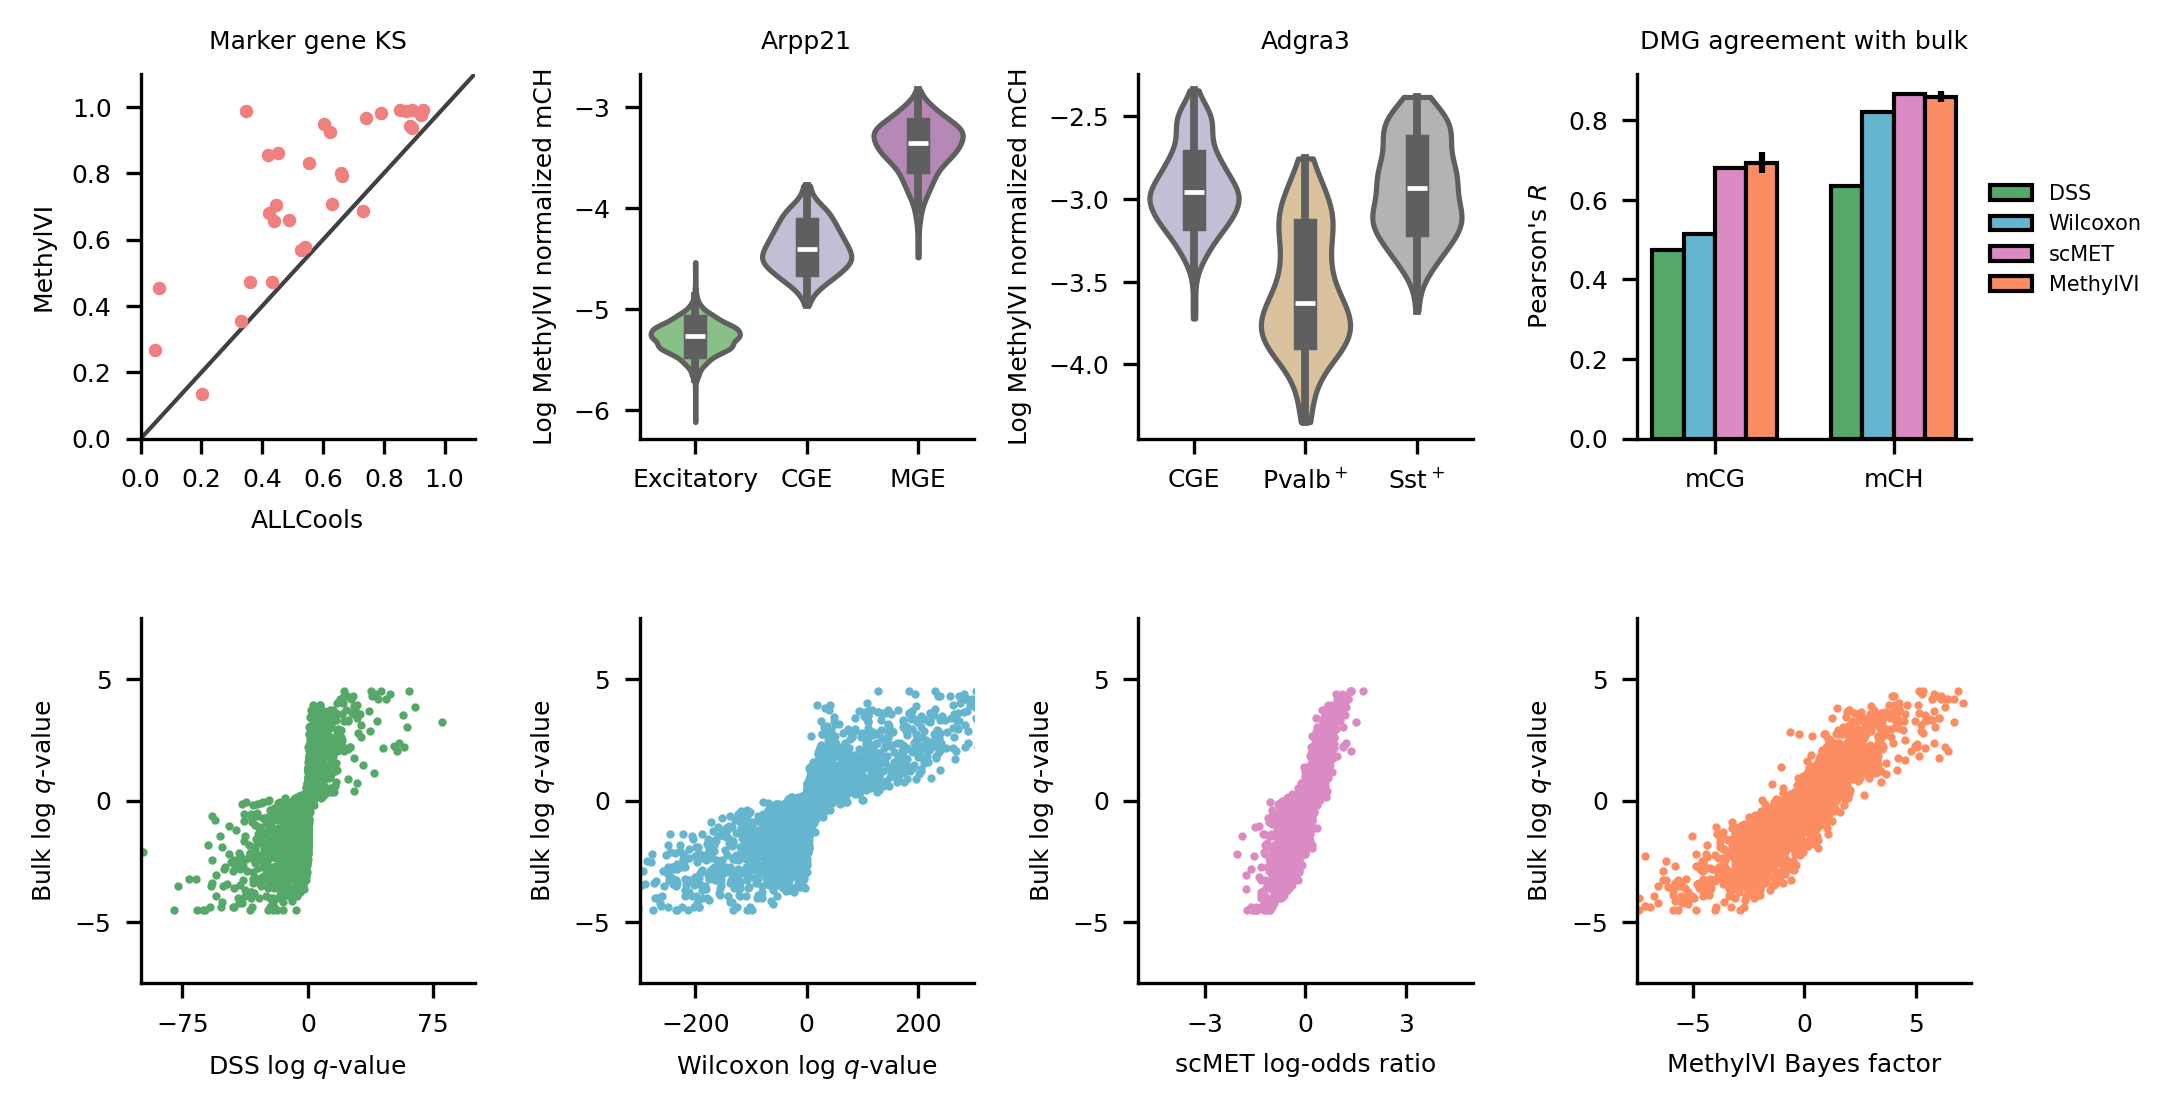

In [21]:
import scanpy as sc
import matplotlib
import seaborn as sns

mm = 1/25.4

fontsize = 6
s=1
border_width = 0.5
width = 0.15
matplotlib.rcParams.update({'font.size': fontsize})
matplotlib.rcParams.update({'axes.titlesize': fontsize})
matplotlib.rcParams.update({'legend.markerscale': 0.5})
matplotlib.rcParams['font.family'] = 'sans-serif'

fig, axes = plt.subplots(2, 4, figsize=(200*mm, 100*mm), dpi=300)

axes[0][0].scatter(
    observed_ks_tests,
    methylVI_ks_tests,
    s=5,
    c='lightcoral'
)

axes[0][0].set_xlim(0, 1.1)
axes[0][0].set_ylim(0, 1.1)

lims = [
    np.min([axes[0][0].get_xlim(), axes[0][0].get_ylim()]),  # min of both axes
    np.max([axes[0][0].get_xlim(), axes[0][0].get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
axes[0][0].plot(lims, lims, 'k-', alpha=0.75, zorder=0, linewidth=1)
axes[0][0].set_xlabel("ALLCools")
axes[0][0].set_ylabel("MethylVI")

axes[0][0].set_title("Marker gene KS")
axes[0][0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

gene1 = "Arpp21"
sc.pl.violin(
    adata,
    keys=gene1,
    groupby="Medium type",
    layer='log_methylVI_imputed',
    inner='box',
    stripplot=False,
    ax=axes[0][1],
    show=False,
    palette={
        "Excitatory": sns.color_palette("Accent")[0],
        "CGE": sns.color_palette("Set3")[2],
        "MGE": sns.color_palette("Set3")[-3],
    }
)

axes[0][1].set_xlabel("")
axes[0][1].set_ylabel("Log MethylVI normalized mCH")
axes[0][1].set_title(gene1)


gene2 = 'Adgra3'
sc.pl.violin(
    adata[adata.obs['Medium type'] != "Excitatory"],
    keys=gene2,
    groupby="adgra_labels",
    layer='log_methylVI_imputed',
    inner='box',
    stripplot=False,
    ax=axes[0][2],
    show=False,
    palette={
        "Pvalb$^+$": sns.color_palette("Set2")[-2],
        "Sst$^+$": sns.color_palette("Set2")[-1],
        "MGE": sns.color_palette("Set3")[-3],
        "CGE": sns.color_palette("Set3")[2],
    }
)

axes[0][2].set_xlabel("")
axes[0][2].set_ylabel("Log MethylVI normalized mCH")
axes[0][2].set_title(gene2)

methylVI_idx = (1, 3)
wilcoxon_idx = (1, 1)
dss_idx = (1, 0)
scmet_idx = (1, 2)

colors = {
    "methylVI": sns.color_palette("Set2")[1],
    "Wilcoxon": sns.color_palette("deep")[-1],
    "DSS": sns.color_palette("deep")[2],
    "methylKit": sns.color_palette("deep")[-2],
    "scMET": sns.color_palette("deep")[-4],
}

methylVI_scatter = axes[methylVI_idx].scatter(
    x=results_dict[modality][f'{group1}_{group2}']['methylVI'][0],
    y=limma_vals_dict[modality][f'{group1}_{group2}'],
    s=s,
    color=colors['methylVI'],
    label='MethylVI',
    rasterized=True
)
axes[methylVI_idx].set_xlabel("MethylVI Bayes factor")
axes[methylVI_idx].set_xlim([-7.5, 7.5])
axes[methylVI_idx].set_xticks([-5, 0, 5])

dss_scatter = axes[dss_idx].scatter(
    x=results_dict[modality][f'{group1}_{group2}']['DSS'],
    y=limma_vals_dict[modality][f'{group1}_{group2}'],
    s=s,
    color=colors['DSS'],
    label="DSS",
    rasterized=True
)
axes[dss_idx].set_xlabel("DSS log $q$-value")
axes[dss_idx].set_xlim(-100, 100)
axes[dss_idx].set_xticks([-75, 0, 75])

wilcoxon_scatter = axes[wilcoxon_idx].scatter(
    x=results_dict[modality][f'{group1}_{group2}']['Wilcoxon'],
    y=limma_vals_dict[modality][f'{group1}_{group2}'],
    s=s,
    color=colors['Wilcoxon'],
    label="Wilcoxon",
    rasterized=True
)
axes[wilcoxon_idx].set_xlabel("Wilcoxon log $q$-value")
axes[wilcoxon_idx].set_xlim(-300, 300)

scmet_scatter = axes[scmet_idx].scatter(
    x=results_dict[modality][f'{group1}_{group2}']['scMET'][0],
    y=limma_vals_dict[modality][f'{group1}_{group2}'],
    s=s,
    color=colors['scMET'],
    label="scMET",
    rasterized=True
)
axes[scmet_idx].set_xlabel("scMET log-odds ratio")

for ax in [axes[dss_idx], axes[scmet_idx], axes[wilcoxon_idx], axes[methylVI_idx]]:
    ax.set_ylim(-7.5, 7.5)
    ax.set_yticks([-5, 0, 5])
    ax.set_ylabel("Bulk log $q$-value")

for ax in [axes[scmet_idx]]:
    ax.set_xticks([-3, 0, 3])
    ax.set_xlim(-5, 5)

methods = metric_mean.keys()

width = 0.175
positions = np.arange(len(modalities))
multiplier = 0
hatches = [None, '//']

for i, method in enumerate(methods):
    offset = width*multiplier
    rects = axes[0][3].bar(
        positions + offset,
        height=[metric_mean[method][modality] for modality in modalities],
        color=colors[method],
        width=width,
        edgecolor='black',
        label="MethylVI" if method == "methylVI" else method,
        yerr=[metric_stderr[method][modality] for modality in modalities]
    )
    multiplier = multiplier + 1

axes[0][3].set_xticks(positions + offset/2)
axes[0][3].set_xticklabels(
    modalities,
)

sns.despine()
axes[0][3].set_ylabel("Pearson's $R$")
axes[0][3].set_title("DMG agreement with bulk")

axes[0][3].legend(
    frameon=False,
    bbox_to_anchor=(1.0, 0.75),
    fontsize=5
)

sns.despine()

plt.subplots_adjust(hspace=12.5*mm, wspace=12.5*mm)

plt.savefig("denoising.pdf", transparent=True, dpi=300)